In [1]:
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.applications import InceptionV3
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.inception_v3 import preprocess_input
from IPython.display import Image, display

from tensorflow.keras.preprocessing import image

In [2]:
dir  = 'augmented_dataset'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir
)

Found 11864 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names
class_list = {}
for i, classes in enumerate(class_names):
    class_list[i] = classes

print(class_list)

{0: 'Bacterial Blight', 1: 'Blast', 2: 'Brown Spot', 3: 'Tungro'}


Class Bacterial Blight: 3168 images
Class Blast: 2880 images
Class Brown Spot: 3200 images
Class Tungro: 2616 images
11864


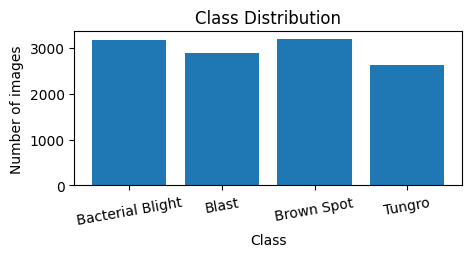

In [5]:
from collections import Counter

def distribution_class(dir):
    class_dirs = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    class_counts = Counter()

    for class_dir in class_dirs:
        class_path = os.path.join(dir, class_dir)
        class_counts[class_dir] = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        
    total = 0 
    for class_name, count in class_counts.items():
        total += count
        print(f'Class {class_name}: {count} images')

    print(total)

    plt.figure(figsize=(5,2))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class Distribution')
    plt.xticks(rotation=10)
    plt.show()

distribution_class(dir)

# Parameter

In [5]:
height = 299
width = 299
batch_size = 32
learning_rate = 0.0001
epoch = 100

Train, Validation, Test Split

In [6]:
# Function to get image paths and labels
def get_image_paths_and_labels(dir):
    image_paths = []
    labels = []
    class_names = os.listdir(dir)
    for class_name in class_names:
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    return image_paths, labels

# Get all image paths and their corresponding labels
image_paths, labels = get_image_paths_and_labels(dir)

# Split the dataset into training, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.4, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

# Function to convert lists of paths and labels to a DataFrame
def path_to_dataframe(image_paths, labels):
    return pd.DataFrame(list(zip(image_paths, labels)), columns=['filename', 'class'])

# Convert to DataFrames
train_df = path_to_dataframe(train_paths, train_labels)
val_df = path_to_dataframe(val_paths, val_labels)
test_df = path_to_dataframe(test_paths, test_labels)

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 7118 validated image filenames belonging to 4 classes.
Found 2373 validated image filenames belonging to 4 classes.
Found 2373 validated image filenames belonging to 4 classes.


# Model

In [18]:
base_model = InceptionV3(
  include_top=False,
  weights="imagenet",
  input_shape=(height, width, 3)
)

Model

In [ ]:
def build_model(dense, dropout, summary = True):
  base_model.trainable = False
  x = base_model.output

  x = GlobalAveragePooling2D()(x)
  if dense > 0:
    x = Dense(dense, activation='relu')(x)
  x = Dropout(dropout)(x)  
  predictions = Dense(len(class_names), activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions, name= f'Dense_{dense}-DO_{dropout}')
  
  if summary:
    model.summary()

  model.compile(
              optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
            )
  
  return model

In [20]:
callback = keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                      )

In [21]:
def fit_model(model, epoch=50):
  history = model.fit(
              train_generator,
              verbose=1,
              epochs=epoch,
              callbacks=callback,
              validation_data = val_generator,
            )
  return history, model

## Train Model

In [31]:
model_0 = build_model(64, 0.3)

Model: "Dense_64-DO_0.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                   

In [32]:
history_0, model_0 = fit_model(model_0)

Epoch 1/50
223/223 [==============================] - 59s 246ms/step - loss: 0.6345 - accuracy: 0.7564 - val_loss: 0.3452 - val_accuracy: 0.8854
Epoch 2/50
223/223 [==============================] - 54s 242ms/step - loss: 0.2988 - accuracy: 0.8984 - val_loss: 0.2294 - val_accuracy: 0.9275
Epoch 3/50
223/223 [==============================] - 55s 245ms/step - loss: 0.2165 - accuracy: 0.9314 - val_loss: 0.1789 - val_accuracy: 0.9461
Epoch 4/50
223/223 [==============================] - 54s 244ms/step - loss: 0.1699 - accuracy: 0.9484 - val_loss: 0.1581 - val_accuracy: 0.9507
Epoch 5/50
223/223 [==============================] - 55s 245ms/step - loss: 0.1388 - accuracy: 0.9604 - val_loss: 0.1251 - val_accuracy: 0.9617
Epoch 6/50
223/223 [==============================] - 64s 288ms/step - loss: 0.1150 - accuracy: 0.9702 - val_loss: 0.1119 - val_accuracy: 0.9680
Epoch 7/50
223/223 [==============================] - 88s 395ms/step - loss: 0.1014 - accuracy: 0.9708 - val_loss: 0.0957 - val_ac

In [40]:
model_1 = build_model(64, 0.4)

Model: "Dense_64-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                   

In [36]:
history_1, model_1 = fit_model(model_1)

Epoch 1/50
223/223 [==============================] - 59s 245ms/step - loss: 0.6531 - accuracy: 0.7534 - val_loss: 0.3429 - val_accuracy: 0.8850
Epoch 2/50
223/223 [==============================] - 53s 237ms/step - loss: 0.3272 - accuracy: 0.8845 - val_loss: 0.2337 - val_accuracy: 0.9305
Epoch 3/50
223/223 [==============================] - 53s 238ms/step - loss: 0.2369 - accuracy: 0.9213 - val_loss: 0.1869 - val_accuracy: 0.9431
Epoch 4/50
223/223 [==============================] - 53s 239ms/step - loss: 0.1879 - accuracy: 0.9394 - val_loss: 0.1524 - val_accuracy: 0.9528
Epoch 5/50
223/223 [==============================] - 54s 240ms/step - loss: 0.1557 - accuracy: 0.9515 - val_loss: 0.1439 - val_accuracy: 0.9553
Epoch 6/50
223/223 [==============================] - 54s 241ms/step - loss: 0.1281 - accuracy: 0.9635 - val_loss: 0.1154 - val_accuracy: 0.9667
Epoch 7/50
223/223 [==============================] - 54s 242ms/step - loss: 0.1120 - accuracy: 0.9684 - val_loss: 0.1005 - val_ac

In [41]:
model_2 = build_model(0, 0.5)

Model: "Dense_0-DO_0.5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                    

In [42]:
history_2, model_2 = fit_model(model_2)

Epoch 1/50
223/223 [==============================] - 60s 250ms/step - loss: 1.1591 - accuracy: 0.4954 - val_loss: 0.7608 - val_accuracy: 0.7429
Epoch 2/50
223/223 [==============================] - 55s 245ms/step - loss: 0.7696 - accuracy: 0.6958 - val_loss: 0.5728 - val_accuracy: 0.7990
Epoch 3/50
223/223 [==============================] - 53s 238ms/step - loss: 0.6115 - accuracy: 0.7711 - val_loss: 0.4713 - val_accuracy: 0.8466
Epoch 4/50
223/223 [==============================] - 53s 238ms/step - loss: 0.5222 - accuracy: 0.8004 - val_loss: 0.4096 - val_accuracy: 0.8689
Epoch 5/50
223/223 [==============================] - 54s 241ms/step - loss: 0.4646 - accuracy: 0.8276 - val_loss: 0.3661 - val_accuracy: 0.8828
Epoch 6/50
223/223 [==============================] - 54s 242ms/step - loss: 0.4192 - accuracy: 0.8502 - val_loss: 0.3332 - val_accuracy: 0.8887
Epoch 7/50
223/223 [==============================] - 54s 242ms/step - loss: 0.3886 - accuracy: 0.8589 - val_loss: 0.3081 - val_ac

In [46]:
build_3 = build_model(0, 0.4)

Model: "Dense_0-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                    

In [48]:
history_3, model_3 = fit_model(build_3)

Epoch 1/50
223/223 [==============================] - 79s 338ms/step - loss: 1.1623 - accuracy: 0.4854 - val_loss: 0.7398 - val_accuracy: 0.7594
Epoch 2/50
223/223 [==============================] - 53s 238ms/step - loss: 0.7222 - accuracy: 0.7266 - val_loss: 0.5514 - val_accuracy: 0.8180
Epoch 3/50
223/223 [==============================] - 53s 239ms/step - loss: 0.5736 - accuracy: 0.7863 - val_loss: 0.4579 - val_accuracy: 0.8479
Epoch 4/50
223/223 [==============================] - 53s 239ms/step - loss: 0.4821 - accuracy: 0.8280 - val_loss: 0.3957 - val_accuracy: 0.8668
Epoch 5/50
223/223 [==============================] - 53s 239ms/step - loss: 0.4309 - accuracy: 0.8457 - val_loss: 0.3541 - val_accuracy: 0.8837
Epoch 6/50
223/223 [==============================] - 54s 240ms/step - loss: 0.3914 - accuracy: 0.8616 - val_loss: 0.3207 - val_accuracy: 0.8976
Epoch 7/50
223/223 [==============================] - 54s 241ms/step - loss: 0.3513 - accuracy: 0.8767 - val_loss: 0.2979 - val_ac

In [69]:
build_4 = build_model(0, 0.3)

Model: "Dense_0-DO_0.3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                    

In [70]:
history_4, model_4 = fit_model(build_4)

Epoch 1/50
223/223 [==============================] - 86s 358ms/step - loss: 1.0362 - accuracy: 0.5677 - val_loss: 0.7237 - val_accuracy: 0.7455
Epoch 2/50
223/223 [==============================] - 53s 237ms/step - loss: 0.6640 - accuracy: 0.7626 - val_loss: 0.5387 - val_accuracy: 0.8146
Epoch 3/50
223/223 [==============================] - 53s 238ms/step - loss: 0.5199 - accuracy: 0.8178 - val_loss: 0.4437 - val_accuracy: 0.8453
Epoch 4/50
223/223 [==============================] - 53s 238ms/step - loss: 0.4437 - accuracy: 0.8469 - val_loss: 0.3830 - val_accuracy: 0.8799
Epoch 5/50
223/223 [==============================] - 54s 240ms/step - loss: 0.3936 - accuracy: 0.8599 - val_loss: 0.3422 - val_accuracy: 0.8921
Epoch 6/50
223/223 [==============================] - 53s 239ms/step - loss: 0.3545 - accuracy: 0.8796 - val_loss: 0.3107 - val_accuracy: 0.9027
Epoch 7/50
223/223 [==============================] - 53s 240ms/step - loss: 0.3208 - accuracy: 0.8901 - val_loss: 0.2853 - val_ac

In [83]:
build_5 = build_model(128, 0.5)

Model: "Dense_128-DO_0.5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                  

In [84]:
history_5, model_5 = fit_model(build_5)

Epoch 1/50
223/223 [==============================] - 89s 379ms/step - loss: 0.6881 - accuracy: 0.7279 - val_loss: 0.3325 - val_accuracy: 0.8820
Epoch 2/50
223/223 [==============================] - 54s 242ms/step - loss: 0.3080 - accuracy: 0.8882 - val_loss: 0.2346 - val_accuracy: 0.9216
Epoch 3/50
223/223 [==============================] - 54s 243ms/step - loss: 0.2211 - accuracy: 0.9278 - val_loss: 0.1685 - val_accuracy: 0.9461
Epoch 4/50
223/223 [==============================] - 54s 244ms/step - loss: 0.1758 - accuracy: 0.9437 - val_loss: 0.1428 - val_accuracy: 0.9515
Epoch 5/50
223/223 [==============================] - 54s 244ms/step - loss: 0.1407 - accuracy: 0.9566 - val_loss: 0.1189 - val_accuracy: 0.9591
Epoch 6/50
223/223 [==============================] - 54s 243ms/step - loss: 0.1212 - accuracy: 0.9645 - val_loss: 0.1050 - val_accuracy: 0.9663
Epoch 7/50
223/223 [==============================] - 54s 244ms/step - loss: 0.1093 - accuracy: 0.9649 - val_loss: 0.0902 - val_ac

In [86]:
build_6 = build_model(128, 0.4)

Model: "Dense_128-DO_0.4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                  

In [87]:
history_6, model_6 = fit_model(build_6)

Epoch 1/50
223/223 [==============================] - 91s 383ms/step - loss: 0.6542 - accuracy: 0.7457 - val_loss: 0.3124 - val_accuracy: 0.8917
Epoch 2/50
223/223 [==============================] - 54s 241ms/step - loss: 0.2838 - accuracy: 0.8994 - val_loss: 0.2174 - val_accuracy: 0.9292
Epoch 3/50
223/223 [==============================] - 54s 242ms/step - loss: 0.2018 - accuracy: 0.9334 - val_loss: 0.1632 - val_accuracy: 0.9494
Epoch 4/50
223/223 [==============================] - 54s 242ms/step - loss: 0.1532 - accuracy: 0.9517 - val_loss: 0.1318 - val_accuracy: 0.9579
Epoch 5/50
223/223 [==============================] - 54s 243ms/step - loss: 0.1267 - accuracy: 0.9633 - val_loss: 0.1104 - val_accuracy: 0.9642
Epoch 6/50
223/223 [==============================] - 55s 245ms/step - loss: 0.1029 - accuracy: 0.9706 - val_loss: 0.1122 - val_accuracy: 0.9629
Epoch 7/50
223/223 [==============================] - 54s 243ms/step - loss: 0.0880 - accuracy: 0.9750 - val_loss: 0.0839 - val_ac

# Evaluation

## Metrics

In [ ]:
# Print classification report
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

def evaluation(model, plot=True, report = True, save=True):
  title = model.name
  heading = f'\n<==== {title} ====>'
  print(heading)
  
  predictions = model.predict(test_generator)
  y_true = test_generator.classes
  y_pred_classes = np.argmax(predictions, axis=1)
  
  if plot:
    conf_matrix = confusion_matrix(y_pred_classes, y_true)
    mat = plt
    mat.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    mat.ylabel('Actual')
    mat.xlabel('Predicted')
    mat.suptitle(title, fontsize=11)    
    mat.savefig('report/confusion_matrix/'+title.replace(".", ",")+'_matrix.png')
    mat.show()
    
  if report:
    test_loss, test_acc = model.evaluate(test_generator)
    acc_loss = f'Test accuracy: {round(test_acc*100,2)}%, test loss: {round(test_loss*100,2)}%'
    print(acc_loss)
    
    target_names = list(test_generator.class_indices.keys())
    clas_report = classification_report(y_true, y_pred_classes, target_names=target_names)
    print(clas_report)
 
  if save:
    dis = plt
    fig, ax = dis.subplots(figsize=(8, 4))
    
    ax.text(0.1, 1, f"<==== {title} ====>", fontsize=11, ha='left')
    ax.text(0.1, 0.85, acc_loss, fontsize=10, ha='left')
    ax.text(0.1, 0.15, "Classification Report: \n" + clas_report, fontsize=10, ha='left', family='monospace')
    ax.axis('off')
    
    dis.savefig(f"report/classification_reports/{title}.png")
    dis.close(fig)

## Train graph

In [73]:
def train_graph(history, title, save = True):
  fig , ax = plt.subplots(1,2)
  train_acc = history['accuracy']
  train_loss = history['loss']
  val_acc = history['val_accuracy']
  val_loss = history['val_loss']
  fig.set_size_inches(9,3)

  ax[0].plot(train_acc)
  ax[0].plot(val_acc)
  ax[0].set_title('Training Accuracy vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'],)

  ax[1].plot(train_loss)
  ax[1].plot(val_loss)
  ax[1].set_title('Training Loss vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'])

  # Add a title for the entire figure
  fig.suptitle(title, fontsize=11)
  plt.subplots_adjust(top=0.85)
  if save:
    plt.savefig('report/train_graph/'+title.replace(".", ",")+'_graph')
  plt.show()

## Manager

In [54]:
def save_model(model):  
  filename = f'model/dense/{model.name}.keras'
  model.save(filename)

import pickle

def save_history(name, history):
  with open(f'model/history/{name}_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
def load_history(name):
  with open(name, 'rb') as file:
      return pickle.load(file)

## Report

In [ ]:
# model = load_model('model/dense/Dense_128-DO_0.3.h5')
# his =  load_history('model/history/Dense_128-DO_0.5_history.pkl')

evaluation(model_6 )
train_graph(history_6.history, model_6.name)
save_model(model_6)
save_history(model_6.name, history_6)

In [ ]:
# # Check available keys
# print("Available keys:", his.keys())

# # Print the last epoch's metrics
# last_epoch = len(his['accuracy']) - 1
# print(f"Last epoch metrics: ", last_epoch)
# print(f"Accuracy: {his['accuracy'][last_epoch]:.4f}")
# print(f"Loss: {his['loss'][last_epoch]:.4f}")

# # If you have validation metrics:
# if 'val_accuracy' in his and 'val_loss' in his:
#     print(f"Validation Accuracy: {his['val_accuracy'][last_epoch]:.4f}")
#     print(f"Validation Loss: {his['val_loss'][last_epoch]:.4f}")


Available keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Last epoch metrics:  40
Accuracy: 0.9989
Loss: 0.0091
Validation Accuracy: 0.9907
Validation Loss: 0.0297


## Predict


In [ ]:
file = 'model/(11-06_11-54)99.494.h5'
this_model = load_model(file)

In [ ]:
class_names = {0: 'Bacterial Blight', 1: 'Blast', 2: 'Brown Spot', 3: 'Tungro'}
height = 299
width = 299

In [59]:
def img_to_array(img_path):
  img = image.load_img(img_path, target_size=(height, width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  return img_array

In [ ]:
def get_prediction(img_path, this_model, class_names):
    img_array = img_to_array(img_path)
   
    predictions = this_model.predict(img_array, verbose=1)
    predicted_index = np.argmax(predictions)

    confidence_score = round(predictions[0][predicted_index] * 100, 3)

    predicted_class = class_names[predicted_index]
    return predicted_class, confidence_score


In [ ]:
img_path = 'dataset/Tungro/TUNGRO1_003.jpg'

predicted_class, confidence_score = get_prediction(img_path, this_model, class_names)
print(f'Predicted class: {predicted_class} with confidence score: {confidence_score} %')


# GradCAM

In [57]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    return heatmap, preds

In [58]:
def get_heatmap(img_path, this_model, pred_id=None, show=False):
  last_conv_layer_name = "mixed10"

  this_model.layers[-1].activation = None
  
  img_arr = img_to_array(img_path)
  heatmap, preds = make_gradcam_heatmap(img_arr, this_model, last_conv_layer_name, pred_id)

  pred_idx = np.argmax(preds[0])
  confidence_level = tf.reduce_max(tf.nn.softmax(preds[0])).numpy()
  score = round(confidence_level * 100, 3)
  
  label = f"{class_names[pred_idx]}, {score}%"
  if show:
    plt.matshow(heatmap)
    plt.show()
  return heatmap, label


In [ ]:
from PIL import Image as PilImage, ImageDraw, ImageFont
import matplotlib as mpl 

def save_and_display_gradcam(img_path, heatmap, max_width=None, cam_path="result", alpha=0.5, label=None, show=True):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path+'.jpg')

    if label != None:
        image_with_text = PilImage.open(cam_path+'.jpg')
        fs = image_with_text.width//18
        draw = ImageDraw.Draw(image_with_text)
        font = ImageFont.truetype("arial.ttf", fs)
        text_size = draw.textbbox((0, 0), label, font=font)
        text_position = (0,0)
        draw.rectangle((text_position[0], text_position[1], text_position[0] + text_size[2], text_position[1] + text_size[3]), fill="black")
        draw.text(text_position, label, fill="white", font=font)
        image_with_text.save(cam_path+'.jpg')
    if show:
        display(Image(filename=cam_path+'.jpg', width=max_width))


## Predict and show GradCAM

In [ ]:
blast  = 'dataset/Blast/BLAST1_006.jpg'
tungro = 'dataset/Tungro/TUNGRO1_003.jpg'
blight = 'dataset/Bacterial Blight/BACTERAILBLIGHT3_008.jpg'
brownspot = 'dataset/Brown Spot/brownspot_orig_003.jpg'


for root, dirs, files in os.walk('model/dense'):
  for file in files:
    dir = os.path.join(root, file)
    model = load_model(dir)
    print(f'..{model.name}       {dir}')
    for c in [blast, tungro, blight, brownspot]:
      name = os.path.basename(os.path.dirname(c))
      heatmap, label = get_heatmap(c, model)
      save_and_display_gradcam(c, heatmap, 300, alpha=0.7, cam_path=f'{name}/{model.name}', show=False)

# heatmap, label = get_heatmap('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', model_0)
# save_and_display_gradcam('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', heatmap, 300, alpha=0.7)
# heatmap, label = get_heatmap('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', model_1)
# save_and_display_gradcam('dataset/Bacterial Blight/BACTERAILBLIGHT3_003.jpg', heatmap, 300, alpha=0.7)

..100_Dense_0-DO_0.5       model/dense\100_Dense_0-DO_0.5.keras
..100_Dense_128-DO_0.3       model/dense\100_Dense_128-DO_0.3.keras
..100_Dense_128-DO_0.5       model/dense\100_Dense_128-DO_0.5.keras
..100_Dense_64-DO_0.5       model/dense\100_Dense_64-DO_0.5.keras
..Dense_0-DO_0.3       model/dense\Dense_0-DO_0.3.keras
..Dense_0-DO_0.4       model/dense\Dense_0-DO_0.4.keras
..Dense_0-DO_0.5       model/dense\Dense_0-DO_0.5.keras
..Dense_128-DO_0.3       model/dense\Dense_128-DO_0.3.h5
..Dense_128-DO_0.4       model/dense\Dense_128-DO_0.4.keras
..Dense_128-DO_0.5       model/dense\Dense_128-DO_0.5.keras
..Dense_64-DO_0.3       model/dense\Dense_64-DO_0.3.keras
..Dense_64-DO_0.4       model/dense\Dense_64-DO_0.4.keras
..Dense_64-DO_0.5       model/dense\Dense_64-DO_0.5.h5


# Test

In [ ]:
test_dir = 'img/test'
check = datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# model = load_model('model/dense/Dense_128-DO_0.5.h5')
# predictions = model.predict(check)
# y_pred_classes = np.argmax(predictions, axis=1)
# y_true = check.classes
test_loss, test_acc = model.evaluate(check)
# Print classification report
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))

Found 19 images belonging to 4 classes.
1/1 [==============================] - 2s 2s/step - loss: 7.6450 - accuracy: 0.5263
                  precision    recall  f1-score   support

Bacterial Blight       0.50      0.75      0.60         4
           Blast       0.29      0.50      0.36         4
      Brown Spot       1.00      0.43      0.60         7
          Tungro       0.67      0.50      0.57         4

        accuracy                           0.53        19
       macro avg       0.61      0.54      0.53        19
    weighted avg       0.67      0.53      0.54        19

